In [14]:
! pip install opencv-python  scikit-learn imblearn matplotlib seaborn keras dask numpy

In [7]:
! pip install tensorflow==2.6.0

In [13]:
! pip uninstall opencv-python

^C


In [12]:
import cv2
import cv2.cuda as cuda
image = cv2.imread(r"C:\\Users\\MAK\Downloads\\0d0c80e1-5a98-4dbc-87f6-62bf0309d2a3.jpg")

# Storing the image on GPU
src = cv2.cuda_GpuMat()
src.upload(image)

# Applying the rotation
a = cv2.cuda.rotate(src=src, dsize = (414,500), angle = 12, xShift= 0, yShift=0, interpolation=cv2.INTER_NEAREST)

# Downloading the image from GPU and visualizing the image
result = a.download()
cv2.imshow("cat", result)
cv2.waitKey(0)


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\core\include\opencv2/core/private.cuda.hpp:106: error: (-216:No CUDA support) The library is compiled without CUDA support in function 'throw_no_cuda'


In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import h5py

def read_video_frames(video_path, target_shape=(224, 224), batch_size=50):
    """Read frames from a video file in batches."""
    cap = cv2.VideoCapture(video_path)
    frames_batch = []
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        frame = cv2.resize(frame, target_shape)
        frames_batch.append(frame.astype(np.uint8))
        
        if len(frames_batch) == batch_size:
            yield frames_batch
            frames_batch = []
    
    if frames_batch:
        yield frames_batch
    
    cap.release()

def read_image(image_path, target_shape=(224, 224)):
    """Read and resize an image file."""
    try:
        frame = cv2.imread(image_path)
        return cv2.resize(frame, target_shape).astype(np.uint8)
    except Exception as e:
        print(f"Error reading image {image_path}: {e}")
        return None
def preprocess_files(file_paths, label_mapping, hdf5_file, batch_size=50):
    for file_path in file_paths:
        if file_path.endswith('.jpg') or file_path.endswith('.jpeg'):
            frame = read_image(file_path)
            
            if frame is not None:
                index = hdf5_file['frames'].shape[0]
                hdf5_file['frames'].resize((index + 1,) + frame.shape)
                hdf5_file['frames'][index] = frame
                
                file_name = os.path.basename(file_path)
                hdf5_file['file_names'].resize((index + 1,))
                hdf5_file['file_names'][index] = file_name
                
                category = os.path.basename(os.path.dirname(os.path.dirname(file_path)))
                if category in label_mapping:
                    hdf5_file['labels'].resize((index + 1,))
                    hdf5_file['labels'][index] = label_mapping[category]
        
        elif file_path.endswith('.mp4'):
            for frames_batch in read_video_frames(file_path, batch_size=batch_size):
                index = hdf5_file['frames'].shape[0]
                hdf5_file['frames'].resize((index + len(frames_batch),) + frames_batch[0].shape)
                hdf5_file['frames'][index:index+len(frames_batch)] = frames_batch
                
                file_name = os.path.basename(file_path)
                frame_names = [f"{file_name}_frame{i}" for i in range(len(frames_batch))]
                hdf5_file['file_names'].resize((index + len(frames_batch),))
                hdf5_file['file_names'][index:index+len(frames_batch)] = frame_names
                
                category = os.path.basename(os.path.dirname(os.path.dirname(file_path)))
                if category in label_mapping:
                    hdf5_file['labels'].resize((index + len(frames_batch),))
                    hdf5_file['labels'][index:index+len(frames_batch)] = [label_mapping[category]] * len(frames_batch)


def preprocess_directory(directory_path, label_mapping, hdf5_file, batch_size=50):
    file_paths = []
    
    for category in os.listdir(directory_path):
        category_folder = os.path.join(directory_path, category)
        
        if os.path.isdir(category_folder):
            for subcategory in os.listdir(category_folder):
                subcategory_folder = os.path.join(category_folder, subcategory)
                
                if os.path.isdir(subcategory_folder):
                    for file_name in os.listdir(subcategory_folder):
                        file_path = os.path.join(subcategory_folder, file_name)
                        file_paths.append(file_path)
                        
    print(f"Processing {directory_path}...")
    preprocess_files(file_paths, label_mapping, hdf5_file, batch_size=batch_size)

def preprocess_data(root_folder, hdf5_path, test_size=0.3, batch_size=50):
    label_mapping = {
        'Normal': 0,
        'Suspicious': 1
    }
    
    # Create HDF5 file
    hdf5_file = h5py.File(hdf5_path, 'w')
    hdf5_file.create_dataset('frames', (0, 224, 224, 3), maxshape=(None, 224, 224, 3), dtype=np.uint8)
    hdf5_file.create_dataset('labels', (0,), maxshape=(None,), dtype=np.int32)
    hdf5_file.create_dataset('file_names', (0,), maxshape=(None,), dtype=h5py.string_dtype(encoding='utf-8'))
    
    preprocess_directory(os.path.join(root_folder, 'Frames', 'JPEG_FRAMES'), label_mapping, hdf5_file, batch_size=batch_size)
    preprocess_directory(os.path.join(root_folder, 'Frames', 'MP4_FRAMES'), label_mapping, hdf5_file, batch_size=batch_size)
    preprocess_directory(os.path.join(root_folder, 'Images'), label_mapping, hdf5_file, batch_size=batch_size)
    preprocess_directory(os.path.join(root_folder, 'Videos'), label_mapping, hdf5_file, batch_size=batch_size)
    
    hdf5_file.close()


KeyboardInterrupt: 

Label 0: 297 samples
Label 1: 703 samples


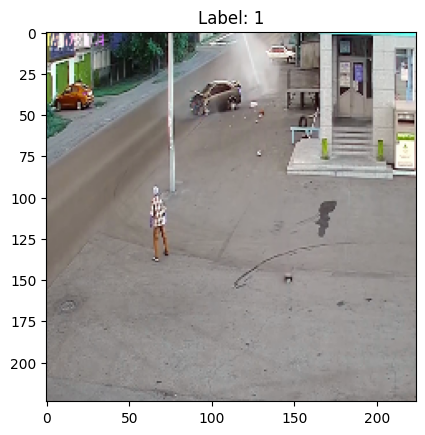

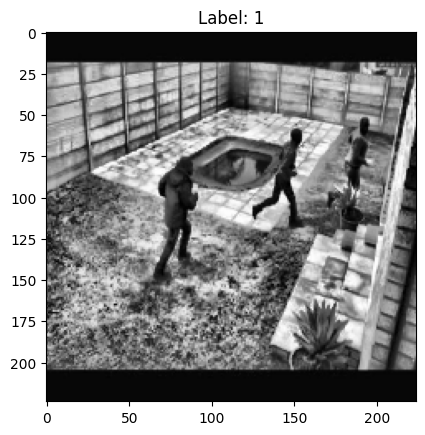

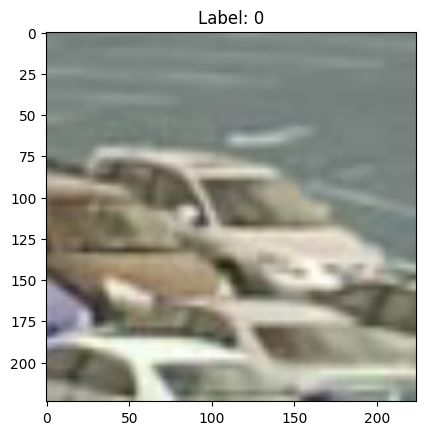

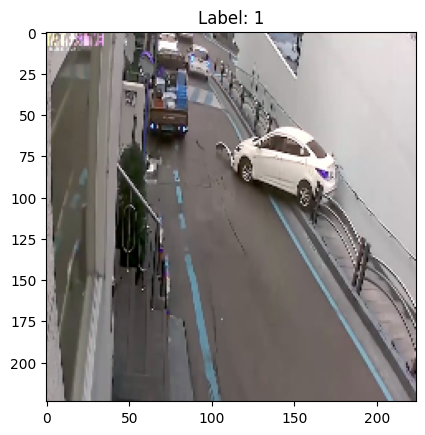

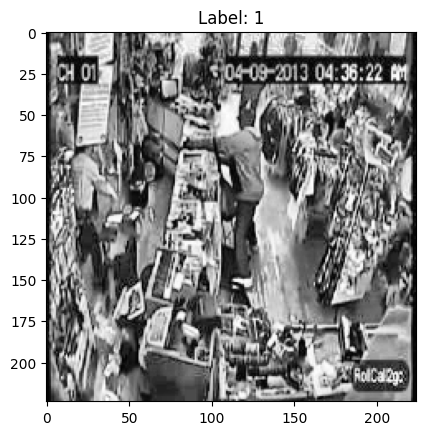

In [15]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load a subset of data for analysis
def load_data_subset(hdf5_path, num_samples=1000):
    with h5py.File(hdf5_path, 'r') as hdf5_file:
        frames = hdf5_file['frames'][:num_samples]
        labels = hdf5_file['labels'][:num_samples]
    return frames, labels

# Analyze label distribution
def analyze_label_distribution(labels):
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique_labels, label_counts):
        print(f"Label {label}: {count} samples")

# Visualize sample frames
def visualize_sample_frames(frames, labels, num_samples=5):
    indices = np.random.choice(len(frames), num_samples, replace=False)
    for index in indices:
        plt.imshow(frames[index])
        plt.title(f"Label: {labels[index]}")
        plt.show()

# Load data subset
frames, labels = load_data_subset(r'D:\Project\preprocessed_data.h5')
# Analyze label distribution
analyze_label_distribution(labels)
# Visualize sample frames
visualize_sample_frames(frames, labels)


In [16]:
import numpy as np
import h5py
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, TimeDistributed
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def data_generator(hdf5_file, indices, batch_size=16):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    total_frames = indices.shape[0]
    while True:
        batch_indices = np.random.choice(indices, size=batch_size)
        frames = hdf5_file['frames'][batch_indices].astype('float32') / 255.0
        labels = hdf5_file['labels'][batch_indices]
        
        augmented_frames = []
        for frame in frames:
            augmented_frame = datagen.random_transform(frame)
            augmented_frames.append(augmented_frame)
            
        yield np.array(augmented_frames), labels

# Open HDF5 file
hdf5_path = r'D:\Project\preprocessed_data.h5'
hdf5_file = h5py.File(hdf5_path, 'r')

input_shape = hdf5_file['frames'].shape[1:]
num_classes = len(np.unique(hdf5_file['labels']))

total_samples = hdf5_file['frames'].shape[0]
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

train_indices = np.random.choice(total_samples, train_size, replace=False)
val_indices = np.random.choice(list(set(range(total_samples)) - set(train_indices)), val_size, replace=False)
test_indices = list(set(range(total_samples)) - set(train_indices) - set(val_indices))

# Sort the indices
train_indices.sort()
val_indices.sort()
test_indices.sort()

# Create data generators
train_generator = data_generator(hdf5_file, train_indices, batch_size=16)
val_generator = data_generator(hdf5_file, val_indices, batch_size=16)
test_generator = data_generator(hdf5_file, test_indices, batch_size=16)

# Close HDF5 file
hdf5_file.close()

# Build model
model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_size // 16,
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=val_size // 16)

# Save the trained model
model.save(r'D:\Project\trained_model.h5')


ImportError: cannot import name 'dtensor' from 'tensorflow.compat.v2.experimental' (c:\Users\MAK\anaconda3\envs\myenv\lib\site-packages\tensorflow\_api\v2\compat\v2\experimental\__init__.py)

In [18]:
with h5py.File(r'D:\Project\preprocessed_data.h5', 'r') as hdf:
    total_frames = hdf['frames'].shape[0]
total_frames

775994

In [34]:
! pip install scikit-image

   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.8 MB 1.1 MB/s eta 0:00:12
   ---------------------------------------- 0.1/12.8 MB 1.1 MB/s eta 0:00:12
   ---------------------------------------- 0.1/12.8 MB 798.9 kB/s eta 0:00:16
    --------------------------------------- 0.2/12.8 MB 1.1 MB/s eta 0:00:12
    --------------------------------------- 0.2/12.8 MB 888.4 kB/s eta 0:00:15
    --------------------------------------- 0.3/12.8 MB 1.1 MB/s eta 0:00:12
   - -------------------------------------- 0.3/12.8 MB 1.1 MB/s eta 0:00:12
   - -------------------------------------- 0.4/12.8 MB 1.1 MB/s eta 0:00:12
   - -------------------------------------- 0.6/12.8 MB 1.2 MB/s eta 0:00:10
   - -------------------------------------- 0.6/12.8 MB 1.3 MB/s eta 0:00:10
   - -------------------------------------- 0.6/12.8 MB 1.3 MB/s eta 0:00:10
   - -------------------------------------- 0.6/12.8 MB 1.3 MB/s eta 0:00:10
  

In [26]:

import h5py
import dask.array as da

# Load HDF5 file
file_path = r'D:/Project/preprocessed_data.h5'  
hdf5_file = h5py.File(file_path, 'r')

# Assuming you have datasets named 'data' and 'labels' in your HDF5 file
data_dask = da.from_array(hdf5_file['frames'], chunks='auto')
labels_dask = da.from_array(hdf5_file['labels'], chunks='auto')

# Close the HDF5 file
hdf5_file.close()


In [21]:
! pip install tables




   ---------------------------------------- 0.0/4.4 MB ? eta -:--:--
   -- ------------------------------------- 0.2/4.4 MB 7.6 MB/s eta 0:00:01
   -- ------------------------------------- 0.3/4.4 MB 4.1 MB/s eta 0:00:01
   --- ------------------------------------ 0.3/4.4 MB 2.7 MB/s eta 0:00:02
   --- ------------------------------------ 0.4/4.4 MB 2.4 MB/s eta 0:00:02
   --- ------------------------------------ 0.4/4.4 MB 2.4 MB/s eta 0:00:02
   --- ------------------------------------ 0.4/4.4 MB 2.4 MB/s eta 0:00:02
   ---- ----------------------------------- 0.5/4.4 MB 1.5 MB/s eta 0:00:03
   ----- ---------------------------------- 0.6/4.4 MB 1.6 MB/s eta 0:00:03
   ------ --------------------------------- 0.7/4.4 MB 1.5 MB/s eta 0:00:03
   ------ --------------------------------- 0.7/4.4 MB 1.5 MB/s eta 0:00:03
   ------- -------------------------------- 0.8/4.4 MB 1.4 MB/s eta 0:00:03
   ------- -------------------------------- 0.8/4.4 MB 1.4 MB/s eta 0:00:03
   ------- --------

In [9]:
import h5py
import cv2
import numpy as np

def motion_detection(frame):
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred_frame = cv2.GaussianBlur(gray_frame, (21, 21), 0)
    
    # Calculate absolute difference between current frame and previous frame
    # Assuming you have a variable to store the previous frame, like prev_frame
    if 'prev_frame' not in globals():
        global prev_frame
        prev_frame = blurred_frame
    
    frame_diff = cv2.absdiff(prev_frame, blurred_frame)
    _, thresh = cv2.threshold(frame_diff, 25, 255, cv2.THRESH_BINARY)
    
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Return True if motion is detected (contours found)
    return len(contours) > 0

def clean_data(input_file, output_file, chunk_size):
    # Open the HDF5 file for reading
    with h5py.File(input_file, 'r') as infile:
        total_frames = len(infile['frames'])
        num_chunks = (total_frames + chunk_size - 1) // chunk_size
        
        # Open the HDF5 file for writing
        with h5py.File(output_file, 'w') as outfile:
            # Create datasets for cleaned frames and labels
            cleaned_frames = outfile.create_dataset('frames', shape=(total_frames, 224, 224, 3), dtype='uint8')
            cleaned_labels = outfile.create_dataset('labels', shape=(total_frames,), dtype='uint8')
            
            start_idx = 0
            for i in range(num_chunks):
                end_idx = min(start_idx + chunk_size, total_frames)
                
                # Load chunk of frames and labels
                frames_chunk = infile['frames'][start_idx:end_idx]
                labels_chunk = infile['labels'][start_idx:end_idx]
                
                # Clean frames (motion detection)
                cleaned_indices = [idx for idx, frame in enumerate(frames_chunk) if motion_detection(frame)]
                
                # Create an intermediate array to hold the cleaned frames for this chunk
                cleaned_frames_chunk = np.zeros((end_idx - start_idx, 224, 224, 3), dtype=np.uint8)
                
                # Reshape cleaned frames to match dataset's shape
                cleaned_frames_chunk[:len(cleaned_indices)] = frames_chunk[cleaned_indices].reshape(-1, 224, 224, 3)
                
                # Assign the cleaned frames for this chunk to the appropriate slice in the cleaned_frames dataset
                cleaned_frames[start_idx:end_idx] = cleaned_frames_chunk
                
                cleaned_labels[start_idx:end_idx] = labels_chunk[cleaned_indices]
                
                # Update start index for next chunk
                start_idx = end_idx
                
                print(f"Processed chunk {i+1}/{num_chunks}")
                
            print("Data cleaning completed.")

# Example usage
input_file = r'D:\Project\preprocessed_data.h5'
output_file = r'cleaned_dataset.hdf5'
chunk_size = 1000  # Adjust chunk size based on memory constraints

clean_data(input_file, output_file, chunk_size)


NameError: name 'np' is not defined

In [ ]:
import dask as da
def balance_classes(frames, labels):
    # Separate frames and labels by class
    frames_label_0 = frames[labels == 0]
    frames_label_1 = frames[labels == 1]

    # Compute the length of the majority class
    frames_label_0_len = frames_label_0.shape[0]
    
    # Resample the minority class to match the majority class length
    frames_label_1_resampled = da.random.choice(frames_label_1, size=frames_label_0_len, replace=True)

    # Concatenate resampled frames and labels
    frames_balanced = da.concatenate([frames_label_0, frames_label_1_resampled], axis=0)
    labels_balanced = da.concatenate([da.zeros(frames_label_0_len, dtype=labels.dtype),
                                      da.ones(frames_label_0_len, dtype=labels.dtype)], axis=0)

    return frames_balanced, labels_balanced

# Usage:
balanced_frames, balanced_labels = balance_classes(frames, labels)





AttributeError: module 'dask' has no attribute 'random'

In [20]:

print(np.sum(labels==0),np.sum(labels==1))

747686 28308


In [ ]:
def load_frames(file_path, chunk_size):
    return da.from_zarr(file_path, chunks=(chunk_size, ...))
file_path = "path_to_your_dataset.zarr"

In [9]:
import dask as da
def balance_classes(frames, labels):
    # Separate frames and labels by class
    frames_label_0 = frames[labels == 0]
    frames_label_1 = frames[labels == 1]

    # Compute the length of the majority class
    frames_label_0_len = frames_label_0.shape[0]
    
    # Resample the minority class to match the majority class length
    frames_label_1_resampled = da.random.choice(frames_label_1, size=frames_label_0_len, replace=True)

    # Concatenate resampled frames and labels
    frames_balanced = da.concatenate([frames_label_0, frames_label_1_resampled], axis=0)
    labels_balanced = da.concatenate([da.zeros(frames_label_0_len, dtype=labels.dtype),
                                      da.ones(frames_label_0_len, dtype=labels.dtype)], axis=0)

    return frames_balanced, labels_balanced

# Usage:
balanced_frames, balanced_labels = balance_classes(frames, labels)





AttributeError: module 'dask' has no attribute 'random'

In [1]:
import dask.array as da
import numpy as np
from sklearn.utils import resample
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import cv2
import h5py

# Function to load frames and labels from HDF5 file using Dask arrays
def load_data_from_hdf5(file_path, frames_key='frames', labels_key='labels'):
    frames = da.from_array(h5py.File(file_path, 'r')[frames_key], chunks='auto')
    labels = da.from_array(h5py.File(file_path, 'r')[labels_key], chunks='auto')
    return frames, labels

# Function to save frames and labels to HDF5 file
def save_data_to_hdf5(frames, labels, file_path, frames_key='frames', labels_key='labels'):
    with h5py.File(file_path, 'w') as f:
        f.create_dataset(frames_key, data=frames)
        f.create_dataset(labels_key, data=labels)

# Step 2: Cleaning the Dataset
def clean_frames(frames):
    def _clean_frame(frame):
        # Example: Perform cleaning operations on each frame (e.g., noise reduction, background removal)
        cleaned_frame = cv2.medianBlur(frame, 5)  # Example: Median blur for noise reduction
        return cleaned_frame
    return frames.map_blocks(_clean_frame, dtype=np.uint8)

# Step 3: Preprocessing
def preprocess(frames):
    # Resize frames to a uniform size
    resized_frames = da.map_blocks(lambda x: resize(x, (224, 224)), frames, dtype=float)
    # Normalize pixel values to [0, 1]
    normalized_frames = resized_frames / 255.0
    return normalized_frames

# Step 4: Efficient Handling of Large Dataset
# Utilize Dask arrays for efficient processing

# Apply class balancing
def balance_classes(frames, labels):
    frames_minority = frames[labels == 1]
    labels_minority = labels[labels == 1]
    frames_majority = frames[labels == 0]
    labels_majority = labels[labels == 0]

    # Compute chunk sizes to determine the length of Dask arrays
    frames_majority_len = frames_majority.compute_chunk_sizes()[0]
    
    frames_minority_upsampled, labels_minority_upsampled = resample(frames_minority, labels_minority,
                                                                   replace=True,
                                                                   n_samples=frames_majority_len,
                                                                   random_state=42)

    frames_balanced = da.concatenate([frames_majority, frames_minority_upsampled])
    labels_balanced = da.concatenate([labels_majority, labels_minority_upsampled])

    return frames_balanced, labels_balanced

# Load frames and labels from HDF5 file using Dask arrays
frames, labels = load_data_from_hdf5('D:/Project/preprocessed_data.h5')

# Apply class balancing
balanced_frames, balanced_labels = balance_classes(frames, labels)

# Clean the frames
cleaned_frames = clean_frames(balanced_frames)

# Preprocess the frames
preprocessed_frames = preprocess(cleaned_frames)

# Split dataset into train, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(preprocessed_frames, balanced_labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Save preprocessed data to a new HDF5 file
save_data_to_hdf5(X_train, y_train, 'D:/Project/cleaned_data.h5')
save_data_to_hdf5(X_val, y_val, 'D:/Project/cleaned_data.h5', frames_key='X_val', labels_key='y_val')
save_data_to_hdf5(X_test, y_test, 'D:/Project/cleaned_data.h5', frames_key='X_test', labels_key='y_test')



KeyboardInterrupt: 

In [ ]:
def process_data(hdf5_path, test_size=0.3):
    # Split data
    with h5py.File(hdf5_path, 'r') as hf:
        num_samples = hf['frames'].shape[0]
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        
        split_index = int((1 - test_size) * num_samples)
        
        train_indices = indices[:split_index]
        test_indices = indices[split_index:]
        
        X_train = hf['frames'][train_indices]
        y_train = hf['labels'][train_indices]
        train_file_names = hf['file_names'][train_indices]
        
        X_test = hf['frames'][test_indices]
        y_test = hf['labels'][test_indices]
        test_file_names = hf['file_names'][test_indices]
    
    return X_train, X_test, y_train, y_test, train_file_names, test_file_names



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from collections import Counter

def create_mobilenet_lstm_model(input_shape, num_classes):
    base_model = MobileNetV2(input_shape=(input_shape[0], input_shape[1], 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze MobileNet layers
    
    model = Sequential([
        TimeDistributed(base_model),
        TimeDistributed(Flatten()),
        
        LSTM(64),
        Dropout(0.5),
        
        Dense(128, activation='relu'),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_test:", np.unique(y_test))

# Reshape the input data
X_train_reshaped = np.expand_dims(X_train, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped.reshape(-1, X_train_reshaped.shape[-3]*X_train_reshaped.shape[-2]*X_train_reshaped.shape[-1]), y_train)
X_train_resampled = X_train_resampled.reshape(-1, X_train_reshaped.shape[-3], X_train_reshaped.shape[-2], X_train_reshaped.shape[-1])

# Print class distribution after resampling
print("Class distribution in y_train after resampling:", Counter(y_train_resampled))

# Create the MobileNet + LSTM model
input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])
num_classes = len(np.unique(y_train_resampled))
model = create_mobilenet_lstm_model(input_shape, num_classes)

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train_resampled, y_train_resampled, batch_size=32), validation_data=(X_test_reshaped, y_test), epochs=20, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Save the model
model.save('suspicious_activity_detection_mobilenet_lstm_model.h5')




ImportError: cannot import name 'dtensor' from 'tensorflow.compat.v2.experimental' (c:\Users\MAK\anaconda3\envs\myenv\lib\site-packages\tensorflow\_api\v2\compat\v2\experimental\__init__.py)

In [ ]:
epochs = 10
batch_size = 32

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
! pip install scikit-learn

In [4]:
pip install keras==2.6.0

     ---------------------------------------- 1.3/1.3 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
! pip uninstall keras

^C


In [7]:
! pip install tqdm

     -------------------------------------- 78.3/78.3 kB 544.4 kB/s eta 0:00:00


In [3]:
pip install GFILE

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement GFILE (from versions: none)
ERROR: No matching distribution found for GFILE


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm

batch_size = 32
tf.debugging.set_log_device_placement(True)
def create_model(input_shape):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(train_generator, val_generator, steps_per_epoch, validation_steps, epochs=10):
    # Explicitly set TensorFlow to use the GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
    
    model = create_model(input_shape=(224, 224, 3))
    # Adding ModelCheckpoint callback to save the best model
    checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    # Adding tqdm progress bars
    train_progress = tqdm(total=steps_per_epoch * epochs, desc='Training', position=0)
    val_progress = tqdm(total=validation_steps, desc='Validation', position=0)
    
    model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs,
              validation_data=val_generator, validation_steps=validation_steps,
              callbacks=callbacks_list,
              verbose=1)  # Reverting back to verbose mode
    
    # Close tqdm progress bars
    train_progress.close()
    val_progress.close()
    
    return model


# Define data generator function
def data_generator(file_path, batch_size=16):
    def generator():
        with h5py.File(file_path, 'r') as f:
            frames = f['frames']
            labels = f['labels']
            num_samples = len(frames)
            while True:
                for i in range(0, num_samples, batch_size):
                    batch_frames = frames[i:i+batch_size]
                    batch_labels = labels[i:i+batch_size]
                    yield np.array(batch_frames), np.array(batch_labels)
        f.close()  # Close the HDF5 file explicitly
    
    return tf.data.Dataset.from_generator(generator, output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    ))

# Load data using custom data generator
data_file = r'D:\\Project\\preprocessed_data.h5' 

# Create data generator
data_gen = data_generator(data_file)

# Count the number of samples in the dataset
with h5py.File(data_file, 'r') as f:
    num_samples = len(f['frames'])

# Split samples into training and validation sets
train_gen = data_gen.take(int(0.8 * num_samples)).shuffle(buffer_size=num_samples, seed=42)
val_gen = data_gen.skip(int(0.8 * num_samples)).shuffle(buffer_size=num_samples, seed=42)

# Calculate steps per epoch and validation steps
steps_per_epoch = int(0.8 * num_samples) // batch_size
validation_steps = int(0.2 * num_samples) // batch_size

# Train model
trained_model = train_model(train_gen, val_gen, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=10)

# Save the best trained model
best_model = create_model(input_shape=(224, 224, 3))
best_model.load_weights("best_model.keras")
best_model.save("saved_model")


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhos

Validation:   0%|          | 0/4849 [00:00<?, ?it/s]

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/10
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

SyntaxError: invalid syntax (1231269909.py, line 1)

In [4]:
pip show opencv-python


Name: opencv-python
Version: 4.9.0.80
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/opencv/opencv-python
Author: 
Author-email: 
License: Apache 2.0
Location: c:\users\mak\anaconda3\envs\myenv\lib\site-packages
Requires: numpy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip list


Package                       Version
----------------------------- --------
absl-py                       0.15.0
aiohttp                       3.8.3
aiosignal                     1.3.1
astor                         0.8.1
astunparse                    1.6.3
async-timeout                 4.0.3
asynctest                     0.13.0
attrs                         23.2.0
backcall                      0.2.0
backports.functools-lru-cache 2.0.0
blinker                       1.6.3
Brotli                        1.0.9
cached-property               1.5.2
cachetools                    4.2.4
certifi                       2024.2.2
cffi                          1.15.1
charset-normalizer            2.1.1
clang                         5.0
click                         8.1.3
cloudpickle                   2.2.1
colorama                      0.4.6
cryptography                  38.0.2
cycler                        0.11.0
dask                          2022.2.0
debugpy                       1.6.3
decorator    